In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.tabular import *

In [7]:
from time import time

In [8]:
#Data von https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
trainDataFilePath = '/content/drive/My Drive/HousePricePrediction_data/train.csv'
testDataFilePath = '/content/drive/My Drive/HousePricePrediction_data/test.csv'

In [9]:
trainData = pd.read_csv(trainDataFilePath)
testData = pd.read_csv(testDataFilePath)

In [10]:
# Tabellen-Information anzeigen-
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [11]:
trainData.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


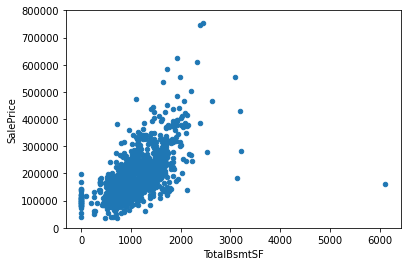

In [37]:
dataSet = pd.concat([trainData['SalePrice'], trainData[var]], axis=1)
dataSet.plot.scatter(x='TotalBsmtSF', y='SalePrice', ylim=(0,800000));

In [12]:
resVal = 'SalePrice'

In [13]:
categories = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
             'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual',
             'OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
             'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'
             ,'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu'
             ,'GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','PavedDrive'
             ,'PoolQC','Fence','MiscFeature','SaleType','SaleCondition']


In [14]:
procs = [FillMissing, Categorify, Normalize]

In [15]:
tabList = TabularList.from_df(testData, cat_names=categories, procs=procs)

In [16]:
preparedData = (TabularList.from_df(trainData, path='.', cat_names=categories, procs=procs)
                        .split_by_rand_pct(valid_pct = 0.1, seed = 42) #TODO Genaue Erklärung (?)
                        .label_from_df(cols = resVal, label_cls = FloatList, log = True )
                        .add_test(tabList)
                        .databunch()) 

In [17]:
preparedData.show_batch(rows=5)

MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,target
80,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SLvl,5,8,Gable,CompShg,HdBoard,HdBoard,BrkFace,Gd,TA,CBlock,Gd,Gd,Av,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,#na#,Attchd,1977.0,Unf,TA,TA,Y,#na#,#na#,#na#,WD,Normal,11.917724
50,C (all),Pave,#na#,IR1,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Feedr,1Fam,1.5Fin,3,2,Hip,CompShg,Plywood,Plywood,None,Fa,Fa,CBlock,TA,Fa,No,Unf,Unf,GasA,TA,N,SBrkr,Fa,Typ,#na#,#na#,#na#,#na#,#na#,#na#,N,#na#,MnPrv,#na#,ConLD,Abnorml,11.350407
90,RL,Pave,#na#,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,Duplex,1Story,3,4,Gable,CompShg,Stucco,Stucco,BrkFace,TA,TA,Slab,#na#,#na#,#na#,#na#,#na#,Wall,Fa,N,FuseA,TA,Typ,#na#,Detchd,1949.0,Unf,TA,TA,Y,#na#,#na#,#na#,WD,Normal,11.379395
90,RL,Pave,#na#,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,Gd,TA,No,Unf,Unf,GasA,TA,Y,SBrkr,TA,Typ,#na#,#na#,#na#,#na#,#na#,#na#,Y,#na#,#na#,#na#,WD,Normal,11.82041
20,RL,Pave,#na#,IR1,Lvl,AllPub,CulDSac,Gtl,Somerst,RRNn,Norm,1Fam,1Story,8,5,Hip,CompShg,VinylSd,VinylSd,Stone,Gd,TA,PConc,Ex,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,2006.0,RFn,TA,TA,Y,#na#,#na#,#na#,New,Partial,12.577636


In [18]:
learner = tabular_learner(preparedData,layers=[200,100],metrics=accuracy) #metrics=root_mean_squared_error - Warum?

In [19]:
# Finden der Lernrate
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


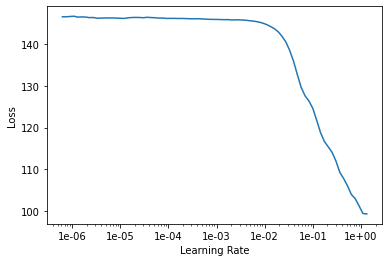

In [20]:
# Anzeigen der Lernkurve
learner.recorder.plot()

In [21]:
learner.fit_one_cycle(15, max_lr=1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,133.597702,109.312935,0.000000,00:00
1,73.432709,8.406416,0.000000,00:00
2,40.977165,1.777390,0.000000,00:00
3,24.246845,0.198100,0.000000,00:00
4,14.996799,0.178530,0.000000,00:00
5,9.576382,0.492768,0.000000,00:00
6,6.235000,0.121394,0.000000,00:00
7,4.097531,0.028108,0.000000,00:00
8,2.711931,0.047536,0.000000,00:00
9,1.810207,0.043524,0.000000,00:00


In [22]:
# 1. Lerndurchgang speichern
learner.save("learn-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


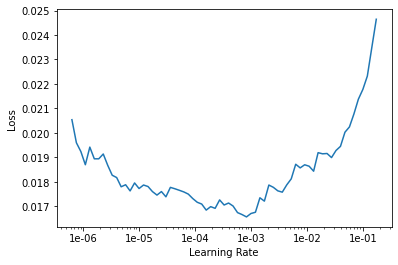

In [23]:
learner.lr_find()
learner.recorder.plot()

In [25]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.018079,0.027831,0.000000,00:00
1,0.018341,0.026286,0.000000,00:00
2,0.018022,0.026343,0.000000,00:00
3,0.017922,0.026539,0.000000,00:00
4,0.018293,0.027981,0.000000,00:00
5,0.017788,0.026051,0.000000,00:00
6,0.017470,0.027183,0.000000,00:00
7,0.017658,0.026416,0.000000,00:00
8,0.017182,0.026547,0.000000,00:00
9,0.016236,0.026641,0.000000,00:00


In [26]:
# 2. Lerndurchgang speichern
learner.save("learn-2")

In [35]:
learner.validate()

[0.026640786, tensor(0.)]

In [36]:
prices = learner.get_preds(ds_type=DatasetType.Test)

In [38]:
finalPrices=np.exp(np.squeeze(prices[0]))

In [40]:
submissionId = pd.read_csv(testDataFilePath,usecols=['Id'])
salePrice = pd.DataFrame(prices,columns=['SalePrice'])
submissionTable = pd.concat([submissionId,salePrice],axis=1)
submissionTable.to_csv("./submission.csv",index = False)